In [1]:
import numpy as np
import scipy.ndimage
import imageio
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [2]:
# Parameters
num_disp_values=128 # these images have disparity between 0 and 15.
Lambda=0.01
nb_iterations=10

The data cost $$D_p(l_p)$$ will use a truncated absolute intensity difference:
$$D_p(l_p)=\min\left(\frac{1}{3}||I_{left}(y,x)-I_{right}(y,x-l_p)||,\tau\right)$$

In [3]:
def compute_data_cost(I1, I2, num_disp_values, Tau):
    """data_cost: a 3D array of sixe height x width x num_disp_value;
    data_cost(y,x,l) is the cost of assigning the label l to pixel (y,x).
    The cost is min(1/3 ||I1[y,x]-I2[y,x-l]||_1, Tau)."""
    h,w,_ = I1.shape
    dataCost=np.zeros((h,w,num_disp_values))

    for lp in range(num_disp_values):
        dataCost[:, :, lp] = np.minimum(1./3*norm(I1 - np.roll(I2, lp, axis=1), axis=2, ord=1), Tau*np.ones((h, w)))

    return dataCost

The energy minimization problem where l is the disparity value of pixel p, P is the set of pixels in the image, N is the set of undirected edges in the four connected image grid graph and D(l) is the cost of assigning label disparity to a pixel and V(l) is the cost of assigning labels to two neighbouring pixels
$$E(L)=\sum_{p \in P}D_p(l_p)+\lambda \cdot \sum_{p,q\in N}V(l_p-l_q)$$

In [4]:
def compute_energy(dataCost,disparity,Lambda):
    """dataCost: a 3D array of sixe height x width x num_disp_values;
    dataCost(y,x,l) is the cost of assigning the label l to pixel (y,x).
    disparity: array of size height x width containing disparity of each pixel.
    (an integer between 0 and num_disp_values-1)
    Lambda: a scalar value.
    Return total energy, a scalar value"""
    h,w,num_disp_values = dataCost.shape

    hh, ww = np.meshgrid(range(h), range(w), indexing='ij')
    dplp = dataCost[hh, ww, disparity]

    # Unitary cost of assigning this disparity to each pixel
    energy = np.sum(dplp)

    # Compute interaction cost of each neighbors
    interactionCostU = Lambda*(disparity - np.roll(disparity, 1, axis=0) != 0)
    interactionCostL = Lambda*(disparity - np.roll(disparity, 1, axis=1) != 0)
    interactionCostD = Lambda*(disparity - np.roll(disparity, -1, axis=0) != 0)
    interactionCostR = Lambda*(disparity - np.roll(disparity, -1, axis=1) != 0)

    # Ignoring edge costs
    interactionCostU[0, :] = 0
    interactionCostL[:, 0] = 0
    interactionCostD[-1, :] = 0
    interactionCostR[:, -1] = 0

    # Adding interaction cost of each neighbors
    energy += np.sum(interactionCostU)
    energy += np.sum(interactionCostL)
    energy += np.sum(interactionCostD)
    energy += np.sum(interactionCostR)

    return energy

For update_msg, after using a python tool, I was able to identify a bottleneck. I got rid of the for loop and replaced it with some numpy broadcasting. The msg* are the updated message maps. The previous messages are taken in as arguments. The data cost is a 3D array with dimensions(height,width,label number). Lambda is the scalar value. The incoming message and data cost are used to calculate the incoming messages. The minimum is then found along the disparity dimension for each pixel. In order to work with different dimensions, newaxis was employed to ensure compatibility. Lastly, the min is calculated for message updating by either the data cost and incoming messages, or the scalar value added to minimum value along the disparity dimension.

In [5]:
def update_msg(msgUPrev,msgDPrev,msgLPrev,msgRPrev,dataCost,Lambda):
    """Update message maps.
    dataCost: 3D array, depth=label number.
    msgUPrev,msgDPrev,msgLPrev,msgRPrev: 3D arrays (same dims) of old messages.
    Lambda: scalar value
    Return msgU,msgD,msgL,msgR: updated messages"""
    msgU=np.zeros(dataCost.shape)
    msgD=np.zeros(dataCost.shape)
    msgL=np.zeros(dataCost.shape)
    msgR=np.zeros(dataCost.shape)

    h,w,num_disp_values = dataCost.shape

    msg_incoming_from_U = np.roll(msgDPrev, 1, axis=0)
    msg_incoming_from_L = np.roll(msgRPrev, 1, axis=1)
    msg_incoming_from_D = np.roll(msgUPrev, -1, axis=0)
    msg_incoming_from_R = np.roll(msgLPrev, -1, axis=1)

    npqU = dataCost + msg_incoming_from_L + msg_incoming_from_D + msg_incoming_from_R
    npqL = dataCost + msg_incoming_from_U + msg_incoming_from_D + msg_incoming_from_R
    npqD = dataCost + msg_incoming_from_L + msg_incoming_from_U + msg_incoming_from_R
    npqR = dataCost + msg_incoming_from_L + msg_incoming_from_D + msg_incoming_from_U

    spqU = np.amin(npqU, axis=2)
    spqL = np.amin(npqL, axis=2)
    spqD = np.amin(npqD, axis=2)
    spqR = np.amin(npqR, axis=2)
    '''
    for lp in range(num_disp_values):
        msgU[:, :, lp] = np.minimum(npqU[:, :, lp], Lambda + spqU)
        msgL[:, :, lp] = np.minimum(npqL[:, :, lp], Lambda + spqL)
        msgD[:, :, lp] = np.minimum(npqD[:, :, lp], Lambda + spqD)
        msgR[:, :, lp] = np.minimum(npqR[:, :, lp], Lambda + spqR)
    '''
    spqU = spqU[:,:,np.newaxis]
    spqL = spqL[:,:,np.newaxis]
    spqD = spqD[:,:,np.newaxis]
    spqR = spqR[:,:,np.newaxis]

    msgU = np.minimum(npqU, Lambda + spqU)
    msgL = np.minimum(npqL, Lambda + spqL)
    msgD = np.minimum(npqD, Lambda + spqD)
    msgR = np.minimum(npqR, Lambda + spqR)

    return msgU,msgD,msgL,msgR

In [6]:
def normalize_msg(msgU,msgD,msgL,msgR):
    """Subtract mean along depth dimension from each message"""

    avg=np.mean(msgU,axis=2)
    msgU -= avg[:,:,np.newaxis]
    avg=np.mean(msgD,axis=2)
    msgD -= avg[:,:,np.newaxis]
    avg=np.mean(msgL,axis=2)
    msgL -= avg[:,:,np.newaxis]
    avg=np.mean(msgR,axis=2)
    msgR -= avg[:,:,np.newaxis]

    return msgU,msgD,msgL,msgR

In [7]:
def compute_belief(dataCost,msgU,msgD,msgL,msgR):
    """Compute beliefs, sum of data cost and messages from all neighbors"""
    beliefs=dataCost.copy()

    msg_incoming_from_U = np.roll(msgD, 1, axis=0)
    msg_incoming_from_L = np.roll(msgR, 1, axis=1)
    msg_incoming_from_D = np.roll(msgU, -1, axis=0)
    msg_incoming_from_R = np.roll(msgL, -1, axis=1)

    beliefs += msg_incoming_from_D + msg_incoming_from_L + msg_incoming_from_R + msg_incoming_from_U

    return beliefs

In [8]:
def MAP_labeling(beliefs):
    """Return a 2D array assigning to each pixel its best label from beliefs
    computed so far"""
    return np.argmin(beliefs, axis=2)

In [9]:
def stereo_bp(I1,I2,num_disp_values,Lambda,Tau=15,num_iterations=60):
    """The main function"""
    dataCost = compute_data_cost(I1, I2, num_disp_values, Tau)
    energy = np.zeros((num_iterations)) # storing energy at each iteration
    # The messages sent to neighbors in each direction (up,down,left,right)
    h,w,_ = I1.shape
    msgU=np.zeros((h, w, num_disp_values))
    msgD=np.zeros((h, w, num_disp_values))
    msgL=np.zeros((h, w, num_disp_values))
    msgR=np.zeros((h, w, num_disp_values))

    print('Iteration (out of {}) :'.format(num_iterations))
    for iter in range(num_iterations):
        print('\t'+str(iter))
        msgU,msgD,msgL,msgR = update_msg(msgU,msgD,msgL,msgR,dataCost,Lambda)
        msgU,msgD,msgL,msgR = normalize_msg(msgU,msgD,msgL,msgR)
        # Next lines unused for next iteration, could be done only at the end
        beliefs = compute_belief(dataCost,msgU,msgD,msgL,msgR)
        disparity = MAP_labeling(beliefs)
        energy[iter] = compute_energy(dataCost,disparity,Lambda)

    return disparity,energy

Display the left and right image. Calculate and display the disparity map and a graph of energy function.

Lambda, number of iterations, and number of disparities were all calculated by using scikit optimize. I ran several tests across different parameters and found that the values used in this notebook provided the best results.

C:\Users\Andrew\AppData\Local\Temp\ipykernel_24456\2807870924.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_left = imageio.imread('./Images/art_view1.png')
C:\Users\Andrew\AppData\Local\Temp\ipykernel_24456\2807870924.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_right = imageio.imread('./Images/art_view5.png')


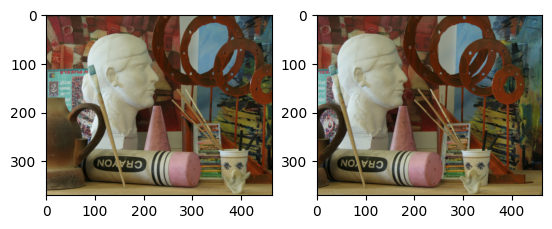

C:\Users\Andrew\AppData\Local\Temp\ipykernel_24456\2807870924.py:21: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  I1=scipy.ndimage.filters.gaussian_filter(img_left, 0.6)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_24456\2807870924.py:22: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  I2=scipy.ndimage.filters.gaussian_filter(img_right, 0.6)


Iteration (out of 10) :
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
int64


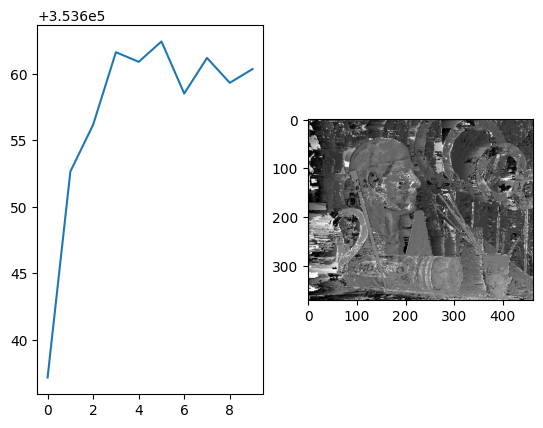

In [10]:
import cv2

# Input
# img_left =imageio.imread('imL.png')
# img_right=imageio.imread('imR.png')
img_left = imageio.imread('./Images/art_view1.png')
img_right = imageio.imread('./Images/art_view5.png')
# img_right = cv2.imread('computer_view5.png')

plt.subplot(121)
plt.imshow(img_left)
plt.subplot(122)
plt.imshow(img_right)
plt.show()

# Convert as float gray images
img_left=img_left.astype(float)
img_right=img_right.astype(float)

# Gaussian filtering
I1=scipy.ndimage.filters.gaussian_filter(img_left, 0.6)
I2=scipy.ndimage.filters.gaussian_filter(img_right, 0.6)

disparity,energy = stereo_bp(I1,I2,num_disp_values,Lambda, num_iterations=nb_iterations)
# imageio.imwrite('output/disparity_{:g}.png'.format(Lambda),disparity)
print(disparity.dtype)
mask = (disparity < 0) | (disparity > 128)
h_mask = (mask.astype(np.uint8)*255)
disparity_32 = disparity.astype(np.float32)
# mask = (mask.astype(np.uint8) * 255)
_,hole_mask = cv2.threshold(h_mask,1,255,cv2.THRESH_BINARY)
disparity_filled = cv2.inpaint(disparity_32,hole_mask, 3, flags=cv2.INPAINT_TELEA)

# Plot results
plt.subplot(121)
plt.plot(energy)
plt.subplot(122)
plt.imshow(disparity,cmap='gray',vmin=0,vmax=num_disp_values-1)
plt.show()

In [11]:
# !pip install scikit-optimize

import numpy as np
import cv2
import imageio
# import scipy.ndimage.filters
# from sklearn.model_selection import train_test_split
# from skopt import gp_minimize
# from skopt.space import Real, Integer
# from skopt.utils import use_named_args
# from skopt.callbacks import VerboseCallback

# Load all the stereo pairs into lists
left_images = []
right_images = []
img_names = ["art","books","computer","dolls","drumsticks","dwarves","laundry","moebius","reindeer"]

for i in range(len(img_names)):
    left_image = cv2.imread(f'Images/{img_names[i]}_view1.png')
    right_image = cv2.imread(f'Images/{img_names[i]}_view5.png')

    left_images.append(left_image)
    right_images.append(right_image)

print(len(left_images))

gaussian = []

for i in range(len(left_images)):
    img_left = left_images[i].astype(float)
    img_right = right_images[i].astype(float)
    I1 = scipy.ndimage.filters.gaussian_filter(img_left, 0.6)
    I2 = scipy.ndimage.filters.gaussian_filter(img_right, 0.6)
    gaussian.append((I1, I2))

print(len(gaussian))



9
9


C:\Users\Andrew\AppData\Local\Temp\ipykernel_24456\1626937673.py:32: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  I1 = scipy.ndimage.filters.gaussian_filter(img_left, 0.6)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_24456\1626937673.py:33: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  I2 = scipy.ndimage.filters.gaussian_filter(img_right, 0.6)


List of left and right images that were smoothed by a gaussian filter. Disparity maps saved to local folder Images for further tests. (RMSE)

In [12]:
for i , (I1,I2) in enumerate(gaussian):
  disparity, _ = stereo_bp(I1, I2, num_disp_values, Lambda, num_iterations=nb_iterations)
  disparity_vis = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  filename = f"Images/disparity_map_{i}.png"  # This will save as 'disparity_map_0.png', 'disparity_map_1.png', etc.
  cv2.imwrite(filename, disparity_vis)

Iteration (out of 10) :
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
Iteration (out of 10) :
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
Iteration (out of 10) :
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
Iteration (out of 10) :
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
Iteration (out of 10) :
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
Iteration (out of 10) :
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
Iteration (out of 10) :
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
Iteration (out of 10) :
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
Iteration (out of 10) :
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9


In [13]:
# Load the disparity maps as grayscale
disparity_map1 = cv2.imread('Images/disparity_map_0.png', 0)
disparity_map2 = cv2.imread('Images/art-d2.png', 0)
disparity_map3 = cv2.imread('Images/disparity_map_1.png', 0)
disparity_map4 = cv2.imread('Images/books-d2.png', 0)
disparity_map5 = cv2.imread('Images/disparity_map_3.png', 0)
disparity_map6 = cv2.imread('Images/dolls-d2.png', 0)
disparity_map7 = cv2.imread('Images/disparity_map_6.png', 0)
disparity_map8 = cv2.imread('Images/laundry-d2.png', 0)
disparity_map9 = cv2.imread('Images/disparity_map_7.png', 0)
disparity_map10 = cv2.imread('Images/moebius-d2.png', 0)
disparity_map11 = cv2.imread('Images/disparity_map_8.png', 0)
disparity_map12 = cv2.imread('Images/reindeer-d2.png', 0)

# Calculate the root mean squared error
error0 = np.sqrt(np.mean((disparity_map1 - disparity_map2)**2))
print(f"RMSE: {error0}")
error1 = np.sqrt(np.mean((disparity_map3 - disparity_map4)**2))
print(f"RMSE: {error1}")
error2 = np.sqrt(np.mean((disparity_map5 - disparity_map6)**2))
print(f"RMSE: {error2}")
error3 = np.sqrt(np.mean((disparity_map7 - disparity_map8)**2))
print(f"RMSE: {error3}")
error4 = np.sqrt(np.mean((disparity_map9 - disparity_map10)**2))
print(f"RMSE: {error4}")
error5 = np.sqrt(np.mean((disparity_map11 - disparity_map12)**2))
print(f"RMSE: {error5}")

RMSE: 10.341200871652443
RMSE: 10.398366923415564
RMSE: 10.558426994423899
RMSE: 10.480444563172483
RMSE: 10.479572820515928
RMSE: 10.485850006833115


In [ ]:
rmse_values = [error0,error1,error2,error3,error4,error5]

disparity_map_names = [
    'Disparity Map 0',
    'Disparity Map 1',
    'Disparity Map 2',
    'Disparity Map 3',
    'Disparity Map 4',
    'Disparity Map 5'
]

plt.figure(figsize(10,6))
plt.bar(disparity_map_names,rmse_values)
plt.xlabel('Disparity Maps')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error of Disparity')
plt.xticks(rotation=45)
plt.show()

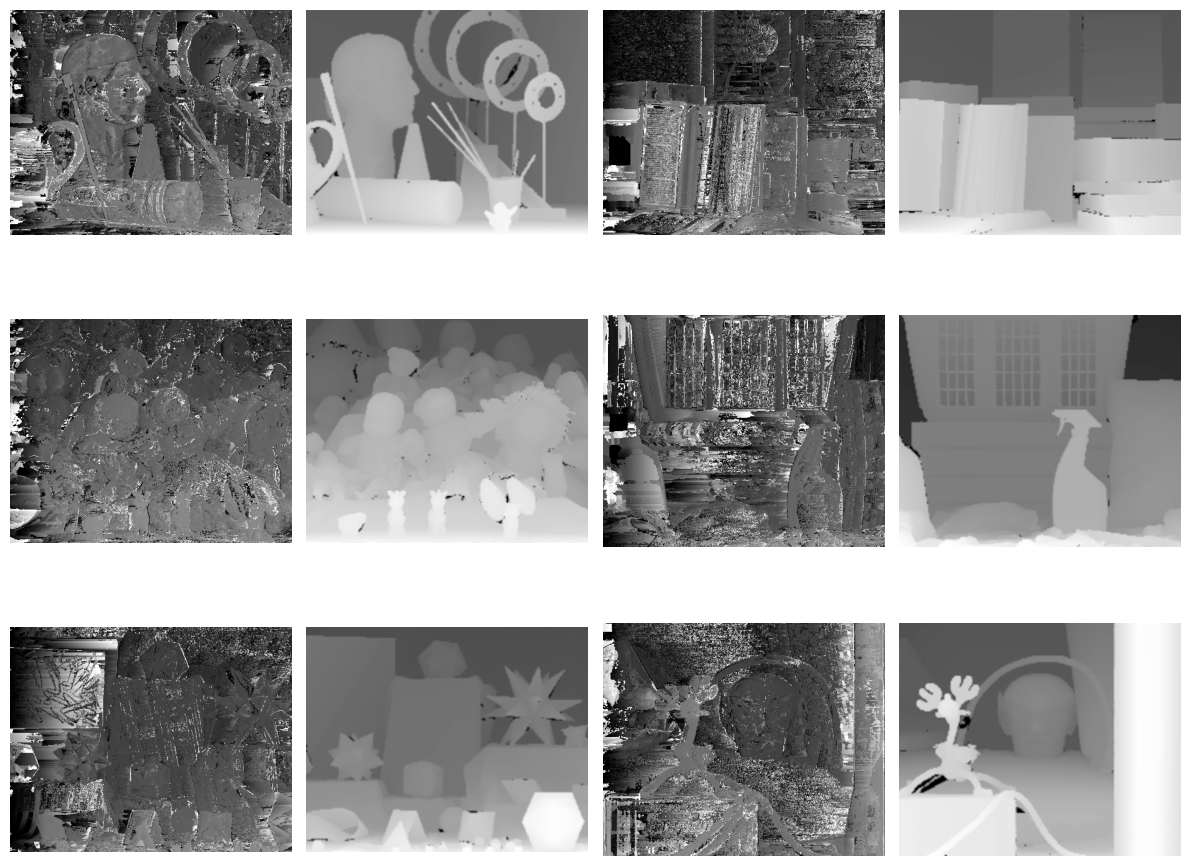

In [14]:
# Create a list of disparity maps
disparity_maps = [
    disparity_map1, disparity_map2, disparity_map3, disparity_map4, disparity_map5,
    disparity_map6, disparity_map7, disparity_map8, disparity_map9, disparity_map10,
    disparity_map11, disparity_map12
]

# Set up subplots for displaying multiple images
num_images = len(disparity_maps)
num_cols = 4
num_rows = (num_images + num_cols - 1) // num_cols

# Display each disparity map
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

for i, disparity_map in enumerate(disparity_maps):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(disparity_map, cmap='gray')
    ax.axis('off')

# If the number of images is not a multiple of the number of columns,
# remove any empty subplots
if num_images % num_cols != 0:
    for j in range(num_images, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()
plt.show()

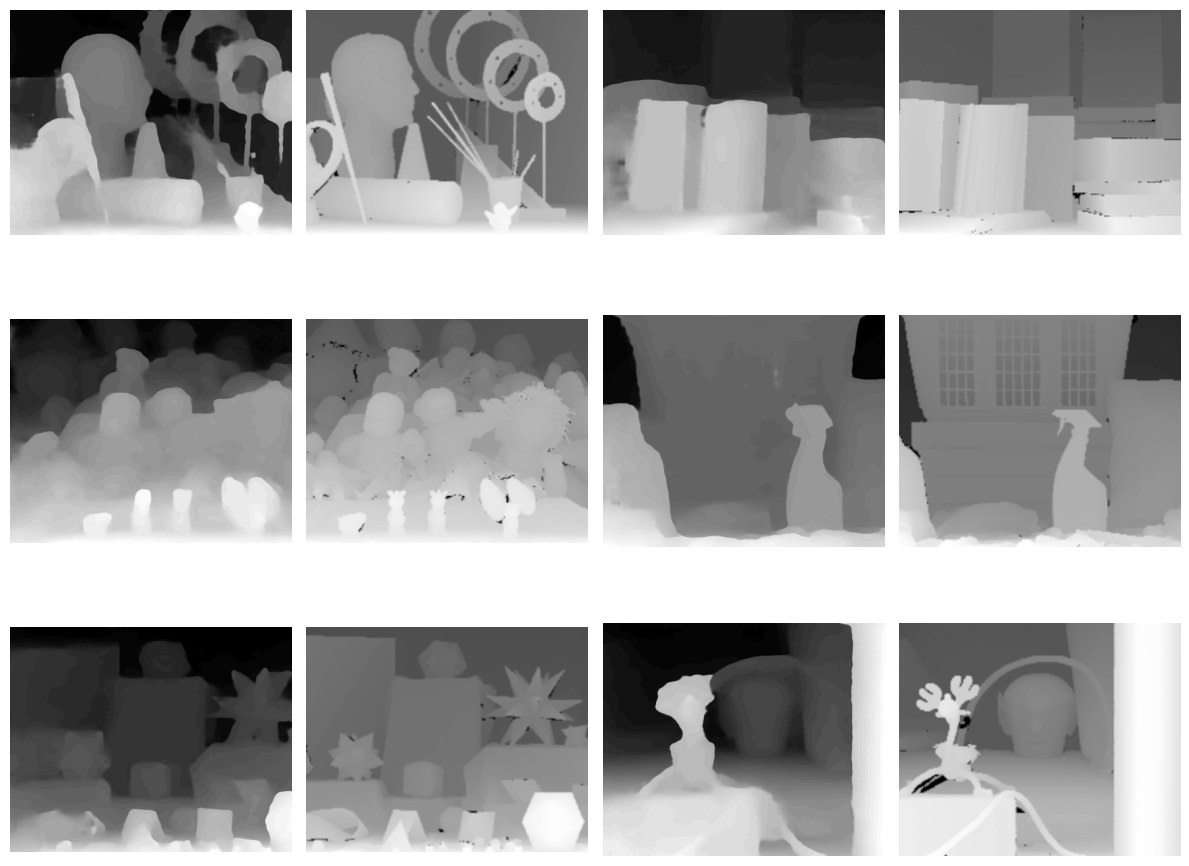

In [17]:
disparity_m1 = cv2.imread('Images/Test_disparity_art.png',0)
disparity_m3 = cv2.imread('Images/Test_disparity_books.png',0)
disparity_m5 = cv2.imread('Images/Test_disparity_dolls.png',0)
disparity_m7 = cv2.imread('Images/Test_disparity_laundry.png',0)
disparity_m9 = cv2.imread('Images/Test_disparity_moebius.png',0)
disparity_m11 = cv2.imread('Images/Test_disparity_reindeer.png',0)
# Create a list of disparity maps
disparity_maps = [
    disparity_m1, disparity_map2, disparity_m3, disparity_map4, disparity_m5,
    disparity_map6, disparity_m7, disparity_map8, disparity_m9, disparity_map10,
    disparity_m11, disparity_map12
]

# Set up subplots for displaying multiple images
num_images = len(disparity_maps)
num_cols = 4
num_rows = (num_images + num_cols - 1) // num_cols

# Display each disparity map
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

for i, disparity_map in enumerate(disparity_maps):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(disparity_map, cmap='gray')
    ax.axis('off')

# If the number of images is not a multiple of the number of columns,
# remove any empty subplots
if num_images % num_cols != 0:
    for j in range(num_images, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()
plt.show()

In [18]:
# Calculate the root mean squared error
error0 = np.sqrt(np.mean((disparity_m1 - disparity_map2)**2))
print(f"RMSE: {error0}")
error1 = np.sqrt(np.mean((disparity_m3 - disparity_map4)**2))
print(f"RMSE: {error1}")
error2 = np.sqrt(np.mean((disparity_m5 - disparity_map6)**2))
print(f"RMSE: {error2}")
error3 = np.sqrt(np.mean((disparity_m7 - disparity_map8)**2))
print(f"RMSE: {error3}")
error4 = np.sqrt(np.mean((disparity_m9 - disparity_map10)**2))
print(f"RMSE: {error4}")
error5 = np.sqrt(np.mean((disparity_m11 - disparity_map12)**2))
print(f"RMSE: {error5}")

RMSE: 10.01333300635765
RMSE: 9.968484282288339
RMSE: 10.418146922629774
RMSE: 10.683569634567219
RMSE: 10.402490799736219
RMSE: 10.129523060775421
